In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import torch
import torch.nn as nn

In [3]:
# setup matplotlib params
plt.rcParams["font.family"] = "Times"

In [4]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [36]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageEnhance
import glob

# create custom dataset class
class OCTDataset(Dataset):
	def __init__(self, data_dir, label=0):
		self.data_dir = data_dir
		# transform to tensor, increase contrast, normalize, resize to 224x224
		self.transform = transforms.Compose(
			[transforms.ToTensor(),
			 transforms.Resize((224, 224), antialias=None),
			 transforms.GaussianBlur(kernel_size=3, sigma=1),
			 transforms.Normalize(mean=[0.4, 0.4, 0.4], std=[0.5, 0.5, 0.5])])

		# list .png files in data_dir
		self.img_list = glob.glob(os.path.join(data_dir, '*'))
		self.label = label

	def __len__(self):
		return len(self.img_list)

	def __getitem__(self, idx):
		img_path = self.img_list[idx]
		is_OS = img_path.split('/')[-1].split('_')[1] == 'OS'
		imgs_pth = sorted(glob.glob(os.path.join(img_path, '*.png')))
		imgs = []

		for img in imgs_pth:
			img = Image.open(img).convert('L')
			img = ImageEnhance.Contrast(img).enhance(2)
			if is_OS:
				img = img.transpose(Image.FLIP_LEFT_RIGHT)
			imgs.append(np.array(img))

		img = np.stack(imgs, axis=-1)
		img = self.transform(img)
		return img, self.label

In [37]:
# load data
AD = OCTDataset(data_dir='../data_3D/3D_AD_OCT', label=1)
AD_normal = OCTDataset(data_dir='../data_3D/3D_AD_normal_OCT', label=0)
CVD_normal = OCTDataset(data_dir='../data_3D/3D_CVD_normal_OCT', label=0)

# discard CVD data to balance dataset
# CVD_normal = torch.utils.data.Subset(CVD_normal, range(0, len(AD)-len(AD_normal)))

# mix data to create one dataset
dataset = torch.utils.data.ConcatDataset([AD, AD_normal, CVD_normal])

In [38]:
print('Number of images in dataset: ', len(dataset))
print('Positive samples: ', len(AD))
print('Negative samples: ', len(AD_normal) + len(CVD_normal))

Number of images in dataset:  287
Positive samples:  133
Negative samples:  154


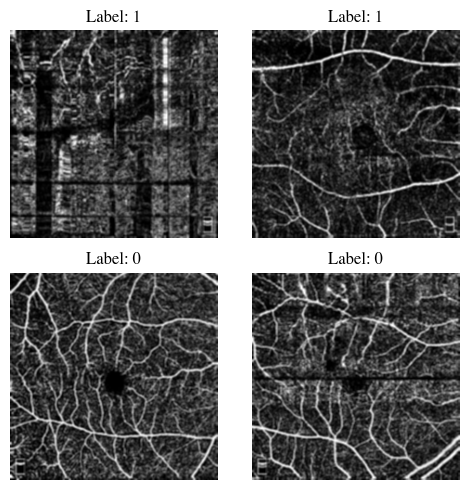

In [8]:
# show some images
fig = plt.figure(figsize=(5, 5))
for i in range(4):
	img, label = dataset[i * 71]
	ax = fig.add_subplot(2, 2, i+1)
	# show one channel of image
	ax.imshow(img[0], cmap='gray')
	ax.set_title('Label: {}'.format(label))
	ax.axis('off')

# save image
plt.tight_layout()
plt.savefig('plots/data.png', dpi=500)

In [39]:
# load pretrained vgg models
from torchvision import models

class VGG(nn.Module):
	def __init__(self, model_name):
		super(VGG, self).__init__()
		if model_name == 'vgg16':
			pretrained_model = models.vgg16(weights="IMAGENET1K_V1")
		elif model_name == 'vgg19':
			pretrained_model = models.vgg19(weights="IMAGENET1K_V1")
		else:
			raise Exception('Choose vgg16 or vgg19')

		self.features = pretrained_model.features
		self.classifier = nn.Sequential(
			nn.Dropout(),
			nn.Linear(512 * 7 * 7, 4096),
			nn.ReLU(True),
			nn.Dropout(),
			nn.Linear(4096, 4096),
			nn.ReLU(True),
			nn.Linear(4096, 1),
		)

		self.sigmoid = nn.Sigmoid()

	def forward(self, x):
		x = self.features(x)
		x = x.view(x.size(0), -1)
		x = self.classifier(x)
		return self.sigmoid(x)


In [40]:
labels = []
for _, label in dataset:
	labels.append(label)

In [41]:
# perform 5 fold cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# create 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
folds = list(skf.split(np.zeros(len(labels)), labels))

In [42]:
# train model
train_loss_list = []
train_acc_list = []
train_precision_list = []
train_recall_list = []
train_f1_list = []

val_loss_list = []
val_acc_list = []
val_precision_list = []
val_recall_list = []
val_f1_list = []

def train_vgg(model_name, warmup_epochs=3, fine_tune_epochs=None, lr=1e-4, batch_size=32):
	fold_count = 1

	# perform 10 fold cross validation
	for train_idx, test_idx in folds:
		# reset model
		model = VGG(model_name)
		model = model.to(device)

		# define loss function and optimizer
		criterion = nn.BCELoss()
		optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

		best_loss = np.inf

		# split train to train and validation
		train_idx, val_idx = train_test_split(train_idx, test_size=0.2, random_state=42)

		# create dataloaders
		train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
		val_loader = DataLoader(torch.utils.data.Subset(dataset, val_idx), batch_size=batch_size, shuffle=True)

		if fine_tune_epochs is None:
			fine_tune_epochs = 0
		else:
			# freeze all layers except last
			for param in model.features.parameters():
				param.requires_grad = False
			for param in model.classifier.parameters():
				param.requires_grad = True

		# train model
		for epoch in range(warmup_epochs + fine_tune_epochs):
			# unfreeze all layers after warmup
			if epoch == warmup_epochs:
				for param in model.parameters():
					param.requires_grad = True

			# train
			model.train()
			train_loss = 0
			train_acc = 0
			train_precision = 0
			train_recall = 0
			train_f1 = 0
			for img, label in train_loader:
				img = img.to(device)
				label = label.to(device)

				# forward pass
				output = model(img)
				loss = criterion(output, label.float().unsqueeze(1))

				# backward pass
				optimizer.zero_grad()
				loss.backward()
				optimizer.step()

				# calculate metrics
				train_loss += loss.item()
				train_acc += accuracy_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
				train_precision += precision_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int), zero_division=1)
				train_recall += recall_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int), zero_division=1)
				train_f1 += f1_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int), zero_division=1)

			# calculate average metrics
			train_loss /= len(train_loader)
			train_acc /= len(train_loader)
			train_precision /= len(train_loader)
			train_recall /= len(train_loader)
			train_f1 /= len(train_loader)

			train_loss_list.append(train_loss)
			train_acc_list.append(train_acc)
			train_precision_list.append(train_precision)
			train_recall_list.append(train_recall)
			train_f1_list.append(train_f1)

			# evaluate model on validation set
			model.eval()

			val_loss = 0
			val_acc = 0
			val_precision = 0
			val_recall = 0
			val_f1 = 0
			for img, label in val_loader:
				img = img.to(device)
				label = label.to(device)

				# forward pass
				output = model(img)
				loss = criterion(output, label.float().unsqueeze(1))

				# calculate metrics
				val_loss += loss.item()
				val_acc += accuracy_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
				val_precision += precision_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int), zero_division=1)
				val_recall += recall_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int), zero_division=1)
				val_f1 += f1_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int), zero_division=1)

			# calculate average metrics
			val_loss /= len(val_loader)
			val_acc /= len(val_loader)
			val_precision /= len(val_loader)
			val_recall /= len(val_loader)
			val_f1 /= len(val_loader)

			val_loss_list.append(val_loss)
			val_acc_list.append(val_acc)
			val_precision_list.append(val_precision)
			val_recall_list.append(val_recall)
			val_f1_list.append(val_f1)

			# print metrics
			print(f'Epoch: {epoch+1}\n\
			Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}\n\
			Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')
			print()

			# save best model
			if val_loss < best_loss:
				best_loss = val_loss
				torch.save(model.state_dict(), f'{model_name}_{fold_count}.pt')

		fold_count += 1



In [43]:
# evaluate model on test set
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

test_loss_list = []
test_acc_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_auc_list = []

def test_vgg(model_name, batch_size=32):
	for i in range(1, 6):
		# load best model
		model = VGG(model_name)
		model.load_state_dict(torch.load(f'{model_name}_{i}.pt'))
		model = model.to(device)
		model.eval()

		test_loader = DataLoader(torch.utils.data.Subset(dataset, folds[i-1][1]), batch_size=batch_size, shuffle=True)

		y_true = []
		y_pred = []

		test_acc = 0
		test_precision = 0
		test_recall = 0
		test_f1 = 0

		for img, label in test_loader:
			img = img.to(device)
			label = label.to(device)

			# forward pass
			output = model(img)

			# calculate metrics
			y_true.extend(label.cpu().numpy())
			y_pred.extend((output.cpu().detach().numpy() > 0.5).astype(int))

			# calculate metrics
			test_acc += accuracy_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
			test_precision += precision_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
			test_recall += recall_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
			test_f1 += f1_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))

		# calculate average metrics
		test_acc /= len(test_loader)
		test_precision /= len(test_loader)
		test_recall /= len(test_loader)
		test_f1 /= len(test_loader)

		test_acc_list.append(test_acc)
		test_precision_list.append(test_precision)
		test_recall_list.append(test_recall)
		test_f1_list.append(test_f1)

		# print metrics
		print(f'Fold: {i} Test Acc: {test_acc:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}')
		print('--------------------------------------------------')


		cm = confusion_matrix(y_true, y_pred)
		sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
		# add title
		plt.title(f'Test Dataset Confusion Matrix for Fold {i}')
		plt.xlabel('Predicted')
		plt.ylabel('True')
		plt.savefig(f'plots/{model_name}/confusion_matrix_{i}.png', dpi=300)
		# clear plot
		plt.clf()

		# auc-roc curve
		fpr, tpr, _ = roc_curve(y_true, y_pred)
		# calculate AUC
		auc_score = auc(fpr, tpr)
		test_auc_list.append(auc_score)

		# plot the roc curve for the model
		plt.plot(fpr, tpr, marker='.', label=f'AUC = {auc_score:.4f}')
		# axis labels
		plt.xlabel('False Positive Rate')
		plt.ylabel('True Positive Rate')
		# show the legend
		plt.legend()
		# save the plot
		plt.savefig(f'plots/{model_name}/roc_curve_{i}.png', dpi=300)
		# clear plot
		plt.clf()



### Train VGG16

In [53]:
train_loss_list = []
train_acc_list = []
train_precision_list = []
train_recall_list = []
train_f1_list = []

val_loss_list = []
val_acc_list = []
val_precision_list = []
val_recall_list = []
val_f1_list = []

warmup_epochs = 5
fine_tune_epochs = 5

# train resnet18
train_vgg('vgg16', warmup_epochs=warmup_epochs, fine_tune_epochs=fine_tune_epochs, lr=1e-5, batch_size=8)

Epoch: 1
			Train Loss: 0.6889, Train Acc: 0.5512, Train Precision: 0.7754, Train Recall: 0.1848, Train F1: 0.2489
			Val Loss: 0.6588, Val Acc: 0.7014, Val Precision: 1.0000, Val Recall: 0.1250, Val F1: 0.1778

Epoch: 2
			Train Loss: 0.6568, Train Acc: 0.6902, Train Precision: 0.7449, Train Recall: 0.5346, Train F1: 0.5854
			Val Loss: 0.6382, Val Acc: 0.7292, Val Precision: 0.9444, Val Recall: 0.4417, Val F1: 0.4833

Epoch: 3
			Train Loss: 0.6262, Train Acc: 0.7057, Train Precision: 0.7739, Train Recall: 0.5312, Train F1: 0.5858
			Val Loss: 0.6220, Val Acc: 0.6944, Val Precision: 0.7778, Val Recall: 0.3667, Val F1: 0.2619

Epoch: 4
			Train Loss: 0.5932, Train Acc: 0.7112, Train Precision: 0.7754, Train Recall: 0.5522, Train F1: 0.6036
			Val Loss: 0.6069, Val Acc: 0.6944, Val Precision: 0.8611, Val Recall: 0.4278, Val F1: 0.4722

Epoch: 5
			Train Loss: 0.5688, Train Acc: 0.7430, Train Precision: 0.8492, Train Recall: 0.6623, Train F1: 0.6801
			Val Loss: 0.6009, Val Acc: 0.7292,

KeyboardInterrupt: 

In [45]:
num_epochs = warmup_epochs + fine_tune_epochs

train_loss_list = np.array(train_loss_list).reshape(5, num_epochs)
train_acc_list = np.array(train_acc_list).reshape(5, num_epochs)
train_precision_list = np.array(train_precision_list).reshape(5, num_epochs)
train_recall_list = np.array(train_recall_list).reshape(5, num_epochs)
train_f1_list = np.array(train_f1_list).reshape(5, num_epochs)

val_loss_list = np.array(val_loss_list).reshape(5, num_epochs)
val_acc_list = np.array(val_acc_list).reshape(5, num_epochs)
val_precision_list = np.array(val_precision_list).reshape(5, num_epochs)
val_recall_list = np.array(val_recall_list).reshape(5, num_epochs)
val_f1_list = np.array(val_f1_list).reshape(5, num_epochs)

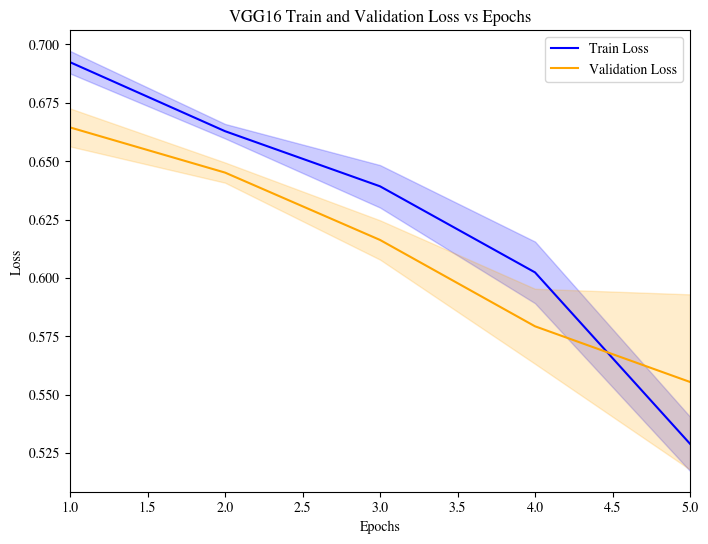

In [46]:
# plot average loss across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_loss_list, axis=0)
std_values = np.std(train_loss_list, axis=0)

plt.plot(epochs, mean_values, label='Train Loss', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(val_loss_list, axis=0)
std_values = np.std(val_loss_list, axis=0)

plt.plot(epochs, mean_values, label='Validation Loss', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
# plt.ylim(0, 1.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG16 Train and Validation Loss vs Epochs')
plt.legend()
plt.savefig('plots/vgg16/loss.png', dpi=300)


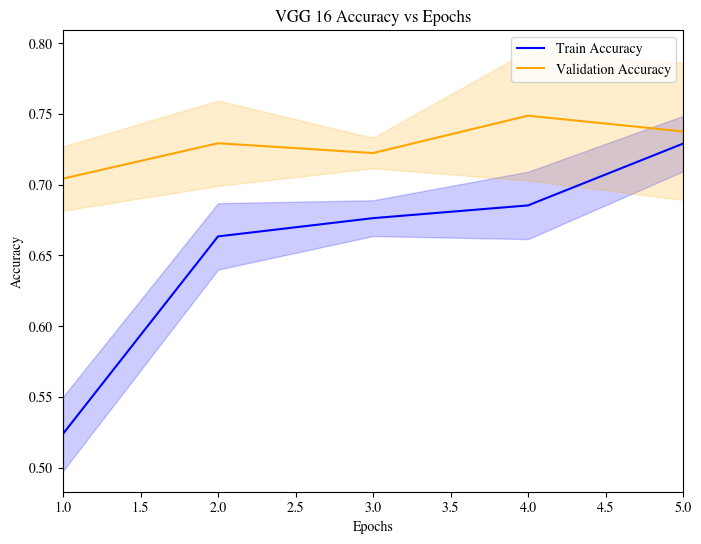

In [47]:
# plot average accuracy across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_acc_list, axis=0)
std_values = np.std(train_acc_list, axis=0)

plt.plot(epochs, mean_values, label='Train Accuracy', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

mean_values = np.mean(val_acc_list, axis=0)
std_values = np.std(val_acc_list, axis=0)

plt.plot(epochs, mean_values, label='Validation Accuracy', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('VGG 16 Accuracy vs Epochs')
plt.legend()
plt.savefig('plots/vgg16/accuracy.png', dpi=300)


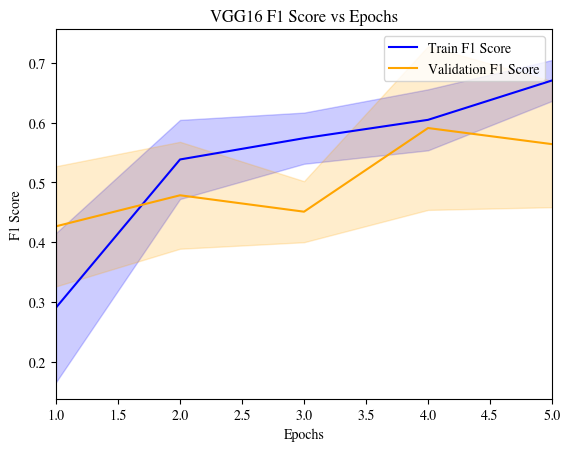

In [48]:
# plot convergence on f1
epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_f1_list, axis=0)
std_values = np.std(train_f1_list, axis=0)

plt.plot(epochs, mean_values, label='Train F1 Score', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

mean_values = np.mean(val_f1_list, axis=0)
std_values = np.std(val_f1_list, axis=0)

plt.plot(epochs, mean_values, label='Validation F1 Score', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('VGG16 F1 Score vs Epochs')
plt.legend()
plt.savefig('plots/vgg16/f1_score.png', dpi=300)


In [49]:
test_loss_list = []
test_acc_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_auc_list = []

# test resnet18
test_vgg('vgg16')

Fold: 1 Test Acc: 0.6466, Test Precision: 0.6357, Test Recall: 0.5682, Test F1: 0.6000
--------------------------------------------------
Fold: 2 Test Acc: 0.6358, Test Precision: 0.7500, Test Recall: 0.3333, Test F1: 0.4603
--------------------------------------------------
Fold: 3 Test Acc: 0.7550, Test Precision: 0.8214, Test Recall: 0.6165, Test F1: 0.7000
--------------------------------------------------
Fold: 4 Test Acc: 0.6881, Test Precision: 0.6966, Test Recall: 0.5774, Test F1: 0.6296
--------------------------------------------------
Fold: 5 Test Acc: 0.7081, Test Precision: 0.7216, Test Recall: 0.5385, Test F1: 0.6131
--------------------------------------------------


<Figure size 640x480 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


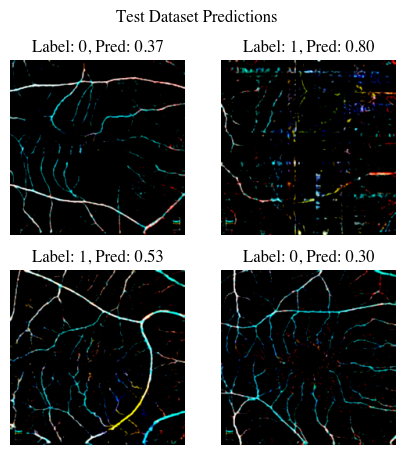

In [50]:
# show some images and predictions
test_loader = DataLoader(torch.utils.data.Subset(dataset, folds[0][1]), batch_size=4, shuffle=True)
model = VGG('vgg16')
model.load_state_dict(torch.load(f'vgg16_1.pt'))

dataiter = iter(test_loader)
img, label = next(dataiter)
img = img.to(device)
label = label.to(device)
output = model(img)

fig = plt.figure(figsize=(5, 5))
for i in range(4):
	ax = fig.add_subplot(2, 2, i+1)
	ax.imshow(img[i].permute(1, 2, 0).cpu().numpy())
	ax.set_axis_off()
	ax.set_title(f'Label: {label[i].cpu().numpy()}, Pred: {(output[i].cpu().detach().numpy())[0]:.2f}')

# add title
plt.suptitle('Test Dataset Predictions')
# save image
plt.savefig('plots/vgg16/predictions.png', dpi=300)

In [51]:
# calculate average metrics for all folds print in latex format
print('&${0:.2f}\pm{1:.2f}$'.format(np.mean(test_acc_list), np.std(test_acc_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_precision_list), np.std(test_precision_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_recall_list), np.std(test_recall_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_f1_list), np.std(test_f1_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_auc_list), np.std(test_auc_list)))

&$0.69\pm0.04$ &$0.73\pm0.06$ &$0.53\pm0.10$ &$0.60\pm0.08$ &$0.67\pm0.05$


In [52]:
# calculate average metrics for all folds
print('Average Test Accuracy: ', np.mean(test_acc_list), np.std(test_acc_list))
print('Average Test Precision: ', np.mean(test_precision_list), np.std(test_precision_list))
print('Average Test Recall: ', np.mean(test_recall_list), np.std(test_recall_list))
print('Average Test F1: ', np.mean(test_f1_list), np.std(test_f1_list))
print('Average Test AUC: ', np.mean(test_auc_list), np.std(test_auc_list))


Average Test Accuracy:  0.6867403846153846 0.04317459094484205
Average Test Precision:  0.7250629925629927 0.0611794714124491
Average Test Recall:  0.526766983016983 0.09987816378307532
Average Test F1:  0.6006084656084656 0.07817769624763939
Average Test AUC:  0.6726376252182704 0.045871989901915856


### Train VGG-19

In [54]:
train_loss_list = []
train_acc_list = []
train_precision_list = []
train_recall_list = []
train_f1_list = []

val_loss_list = []
val_acc_list = []
val_precision_list = []
val_recall_list = []
val_f1_list = []

# train resnet18
warmup_epochs = 10
fine_tune_epochs = 2
train_vgg('vgg19', warmup_epochs=warmup_epochs, fine_tune_epochs=fine_tune_epochs, lr=1e-5, batch_size=8)

Epoch: 1
			Train Loss: 0.6883, Train Acc: 0.5520, Train Precision: 0.6035, Train Recall: 0.5348, Train F1: 0.4854
			Val Loss: 0.6628, Val Acc: 0.6944, Val Precision: 1.0000, Val Recall: 0.1222, Val F1: 0.1786

Epoch: 2
			Train Loss: 0.6543, Train Acc: 0.6731, Train Precision: 0.7942, Train Recall: 0.4516, Train F1: 0.5335
			Val Loss: 0.6555, Val Acc: 0.7083, Val Precision: 0.8333, Val Recall: 0.2778, Val F1: 0.3778

Epoch: 3
			Train Loss: 0.6231, Train Acc: 0.7391, Train Precision: 0.8181, Train Recall: 0.6273, Train F1: 0.6625
			Val Loss: 0.6349, Val Acc: 0.7222, Val Precision: 0.9167, Val Recall: 0.3583, Val F1: 0.3841

Epoch: 4
			Train Loss: 0.5856, Train Acc: 0.7438, Train Precision: 0.8217, Train Recall: 0.6009, Train F1: 0.6507
			Val Loss: 0.6302, Val Acc: 0.7222, Val Precision: 0.9167, Val Recall: 0.3306, Val F1: 0.4008

Epoch: 5
			Train Loss: 0.5554, Train Acc: 0.7438, Train Precision: 0.8094, Train Recall: 0.6370, Train F1: 0.6892
			Val Loss: 0.6246, Val Acc: 0.7153,

In [55]:
num_epochs = warmup_epochs + fine_tune_epochs

train_loss_list = np.array(train_loss_list).reshape(5, num_epochs)
train_acc_list = np.array(train_acc_list).reshape(5, num_epochs)
train_precision_list = np.array(train_precision_list).reshape(5, num_epochs)
train_recall_list = np.array(train_recall_list).reshape(5, num_epochs)
train_f1_list = np.array(train_f1_list).reshape(5, num_epochs)

val_loss_list = np.array(val_loss_list).reshape(5, num_epochs)
val_acc_list = np.array(val_acc_list).reshape(5, num_epochs)
val_precision_list = np.array(val_precision_list).reshape(5, num_epochs)
val_recall_list = np.array(val_recall_list).reshape(5, num_epochs)
val_f1_list = np.array(val_f1_list).reshape(5, num_epochs)

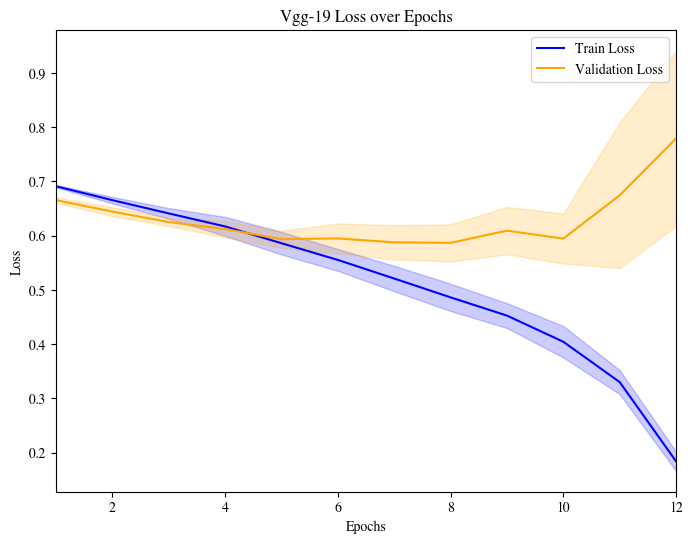

In [56]:
# plot average loss across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_loss_list, axis=0)
std_values = np.std(train_loss_list, axis=0)

plt.plot(epochs, mean_values, label='Train Loss', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(val_loss_list, axis=0)
std_values = np.std(val_loss_list, axis=0)

plt.plot(epochs, mean_values, label='Validation Loss', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
# plt.ylim(0, 1.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Vgg-19 Loss over Epochs')
plt.legend()
plt.savefig('plots/vgg19/loss.png', dpi=300)

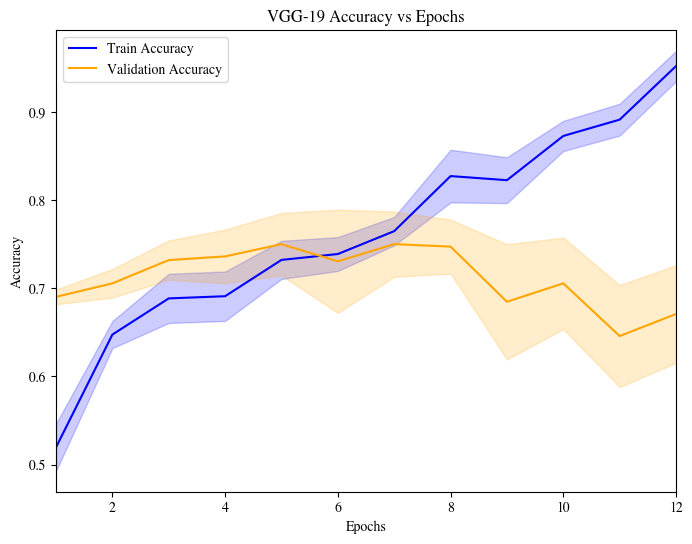

In [57]:
# plot average accuracy across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_acc_list, axis=0)
std_values = np.std(train_acc_list, axis=0)

plt.plot(epochs, mean_values, label='Train Accuracy', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

mean_values = np.mean(val_acc_list, axis=0)
std_values = np.std(val_acc_list, axis=0)

plt.plot(epochs, mean_values, label='Validation Accuracy', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('VGG-19 Accuracy vs Epochs')
plt.legend()
plt.savefig('plots/vgg19/accuracy.png', dpi=300)


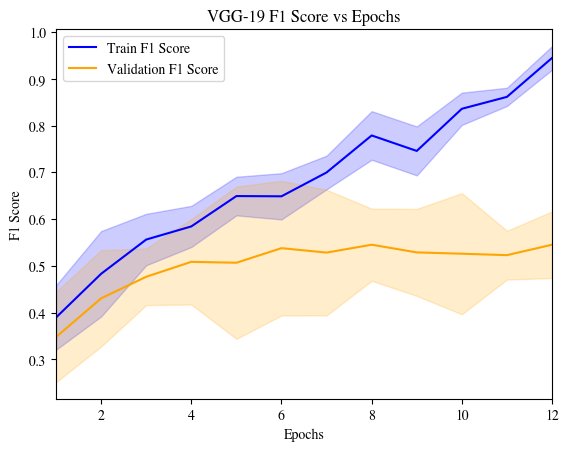

In [58]:
# plot convergence on f1
epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_f1_list, axis=0)
std_values = np.std(train_f1_list, axis=0)

plt.plot(epochs, mean_values, label='Train F1 Score', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

mean_values = np.mean(val_f1_list, axis=0)
std_values = np.std(val_f1_list, axis=0)

plt.plot(epochs, mean_values, label='Validation F1 Score', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('VGG-19 F1 Score vs Epochs')
plt.legend()
plt.savefig('plots/vgg19/f1_score.png', dpi=300)


In [59]:
test_loss_list = []
test_acc_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_auc_list = []

# test vgg19
test_vgg('vgg19')

Fold: 1 Test Acc: 0.5709, Test Precision: 0.5643, Test Recall: 0.3764, Test F1: 0.4472
--------------------------------------------------
Fold: 2 Test Acc: 0.6238, Test Precision: 0.7000, Test Recall: 0.2833, Test F1: 0.4034
--------------------------------------------------
Fold: 3 Test Acc: 0.6969, Test Precision: 0.6619, Test Recall: 0.6917, Test F1: 0.6731
--------------------------------------------------
Fold: 4 Test Acc: 0.7037, Test Precision: 0.6763, Test Recall: 0.6830, Test F1: 0.6667
--------------------------------------------------
Fold: 5 Test Acc: 0.6725, Test Precision: 0.7222, Test Recall: 0.4281, Test F1: 0.5359
--------------------------------------------------


<Figure size 640x480 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


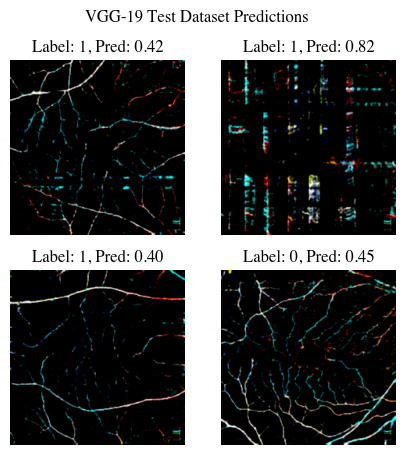

In [60]:
# show some images and predictions
test_loader = DataLoader(torch.utils.data.Subset(dataset, folds[0][1]), batch_size=4, shuffle=True)
model = VGG('vgg19')
model.load_state_dict(torch.load(f'vgg19_1.pt'))

dataiter = iter(test_loader)
img, label = next(dataiter)
img = img.to(device)
label = label.to(device)
output = model(img)

fig = plt.figure(figsize=(5, 5))
for i in range(4):
	ax = fig.add_subplot(2, 2, i+1)
	ax.imshow(img[i].permute(1, 2, 0).cpu().numpy())
	ax.set_axis_off()
	ax.set_title(f'Label: {label[i].cpu().numpy()}, Pred: {(output[i].cpu().detach().numpy())[0]:.2f}')

# add title
plt.suptitle('VGG-19 Test Dataset Predictions')
# save image
plt.savefig('plots/vgg19/predictions.png', dpi=300)

In [61]:
# calculate average metrics for all folds, print in latex
print('&${0:.2f}\pm{1:.2f}$'.format(np.mean(test_acc_list), np.std(test_acc_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_precision_list), np.std(test_precision_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_recall_list), np.std(test_recall_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_f1_list), np.std(test_f1_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_auc_list), np.std(test_auc_list)))

&$0.65\pm0.05$ &$0.66\pm0.05$ &$0.49\pm0.17$ &$0.55\pm0.11$ &$0.64\pm0.05$


In [62]:
# calculate average metrics for all folds
print('Average Test Accuracy: ', np.mean(test_acc_list))
print('Average Test Precision: ', np.mean(test_precision_list))
print('Average Test Recall: ', np.mean(test_recall_list))
print('Average Test F1: ', np.mean(test_f1_list))
print('Average Test AUC: ', np.mean(test_auc_list))


Average Test Accuracy:  0.6535673076923076
Average Test Precision:  0.66493894993895
Average Test Recall:  0.4924969474969475
Average Test F1:  0.5452365557507104
Average Test AUC:  0.6404282694605274
